<a href="https://colab.research.google.com/github/tejas-shanthraj/srh-da3-deep-learning/blob/main/11_Time_Series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling air pollution

Let us try to predict Beijing's air pollution, especially [PM2.5](https://en.wikipedia.org/wiki/Particulates) values in advance!


Inspiration comes from [here](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).

## Dataset

[Beijing PM2.5 Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

### Columns of the dataset:

**No:** row number

**year:** year of data in this row

**month:** month of data in this row

**day:** day of data in this row

**hour:** hour of data in this row

**pm2.5:** PM2.5 concentration

**DEWP:** Dew Point

**TEMP:** Temperature

**PRES:** Pressure

**cbwd:** Combined wind direction

**Iws:** Cumulated wind speed

**Is:** Cumulated hours of snow

**Ir:** Cumulated hours of rain

In [1]:
!pip install seglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 93.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

--2024-12-07 07:13:04--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv’

pollution.csv       100%[===================>]   1.92M  --.-KB/s    in 0.03s   

2024-12-07 07:13:04 (76.4 MB/s) - ‘pollution.csv’ saved [2010492/2010492]



In [4]:
df = pd.read_csv("pollution.csv")
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [6]:
df.drop("No",axis=1, inplace=True)

df["date"]= pd.to_datetime(df['year'].astype(str)+'-'+df['month'].astype(str)+"-"+df["day"].astype(str)+"T"+df["hour"].astype(str).apply(lambda x: x.zfill(2)+":00"))
df.set_index(df.date, inplace=True)

df.drop("date", axis=1, inplace=True)
df.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0


## Encoding day of week

We explicitly encode the day of week, since we assume that weekends and workdays behave differently.

In [7]:
df["dayofweek"] = df.index.dayofweek+1
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,dayofweek
date,,,,,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,5
2010-01-01 01:00:00,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,5
2010-01-01 02:00:00,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,5
2010-01-01 03:00:00,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,5
2010-01-01 04:00:00,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,5


# Decision about NaN-s

In [8]:
df.isnull().sum()

,0
year,0
month,0
day,0
hour,0
pm2.5,2067
DEWP,0
TEMP,0
PRES,0
cbwd,0
Iws,0


In [9]:
def countNullEntries(df):
    return df.isnull().sum()

def countNullPercentByColumn(column):
    values = df.groupby(column)["pm2.5"]
    return values.apply(countNullEntries) / values.count() * 100.0

print("--------------------------------")
print("% NaN datapoints per year:", countNullPercentByColumn("year"))

print("\n--------------------------------")
print("% NaN datapoints per month:", countNullPercentByColumn("month"))

print("\n--------------------------------")
print("% NaN datapoints per dayofweek:", countNullPercentByColumn("dayofweek"))

print("\n--------------------------------")
print("% NaN datapoints per hour:", countNullPercentByColumn("hour"))


--------------------------------
% NaN datapoints per year: year
2010    8.268446
2011    9.063745
2012    5.895118
2013    0.944918
2014    1.143055
Name: pm2.5, dtype: float64

--------------------------------
% NaN datapoints per month: month
1      7.173725
2      0.326119
3      4.611924
4      5.726872
5      3.075644
6      5.726872
7      2.001645
8     11.477375
9      8.010801
10     3.939648
11     2.827763
12     5.055069
Name: pm2.5, dtype: float64

--------------------------------
% NaN datapoints per dayofweek: dayofweek
1    5.757218
2    5.596763
3    4.591752
4    3.809682
5    4.070444
6    4.977376
7    5.882353
Name: pm2.5, dtype: float64

--------------------------------
% NaN datapoints per hour: hour
0     5.244957
1     4.641834
2     5.002875
3     4.641834
4     4.701835
5     4.942529
6     4.942529
7     5.002875
8     5.063291
9     5.002875
10    5.305652
11    5.732484
12    5.488157
13    4.402516
14    5.123777
15    5.002875
16    5.123777
17    4.822

After examining the NaN values in pm2.5, we see no obvious temporal pattern. This is cause for worry, since by simply dropping the rows with NaN values, we can destroy the temporal coherence of the data, hence **data imputation is desirable.**

The autocorrelation charts below imply, that it is not unreasonable to take the previous value to fill NaN-s (high autocorrelation with the previous timestep).

In [10]:
df.fillna(method='ffill', inplace=True)
print(df.isnull().sum())
print("\n")

df.dropna(inplace=True)
print(df.isnull().sum())

year          0
month         0
day           0
hour          0
pm2.5        24
DEWP          0
TEMP          0
PRES          0
cbwd          0
Iws           0
Is            0
Ir            0
dayofweek     0
dtype: int64


year         0
month        0
day          0
hour         0
pm2.5        0
DEWP         0
TEMP         0
PRES         0
cbwd         0
Iws          0
Is           0
Ir           0
dayofweek    0
dtype: int64


<ipython-input-10-ff5b7a388db0>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


# Train, valid, test split - before normalization

Contamination by the normalization values is a distant possibility, but let's stick to paranoid practices.

In [11]:
VALID_AND_TEST_SIZE=0.1

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_else, y_train, y_else = train_test_split(df, df["pm2.5"], test_size=VALID_AND_TEST_SIZE*2, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_else, y_else, test_size=0.5, shuffle=False)

We could have used `temporal_split` from `seglearn`, but that would have cast everything to numpy, so it was more convenient this way for now. Using `seglearn` is encouraged - if we would like to go into classical modeling.

# Data normalization

Our default assumption is to use Scikit's minmax scaler for easier learning by neural models.

But there are some exceptions:

## How to normalize dates?

For the year it is more tricky, it is basically an ordinal.
Subtracting the first year is nice, but how to handle the normalization to 0,1?

We could use 2018 as a max, but **WE WOULD HAVE TO WRITE A BIG CAVEAT MESSAGE FOR DEPLOY PEOPLE!**

So it should be something like  `(df.year - (df.year.min())-1)/((df.year.max()-df.year.min())*2)` (-1 is for avoiding zero, making the life of the network more easy...)

For now we stick to the minmax scaler (living risky... :-)

For month, day, hour default assumption is, scikit's minmax scaler could work, but we will choose a more elaborate solution from [here](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/). This capitalizes on the circular nature of these quasi ordinals.


In [13]:
from sklearn.preprocessing import MinMaxScaler

def minmax_scale(df_x,series_y, normalizers=None):
    features_to_minmax = ["year","pm2.5","DEWP","TEMP","PRES","Iws","Is","Ir"]

    if not normalizers:
        normalizers = {}

    for feat in features_to_minmax:
        if feat not in normalizers:
            normalizers[feat] = MinMaxScaler()
            normalizers[feat].fit(df_x[feat].values.reshape(-1, 1))

        df_x[feat] = normalizers[feat].transform(df_x[feat].values.reshape(-1, 1))

    series_y=normalizers["pm2.5"].transform(series_y.values.reshape(-1, 1))

    return df_x, series_y, normalizers

In [14]:
X_train_norm, y_train_norm, normalizers = minmax_scale(X_train, y_train)
X_valid_norm, y_valid_norm, _ = minmax_scale(X_valid, y_valid, normalizers=normalizers)
X_test_norm, y_test_norm, _ = minmax_scale(X_test, y_test, normalizers=normalizers)

In [15]:
X_train_norm

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,dayofweek
date,,,,,,,,,,,,,
2010-01-02 00:00:00,0.0,1,2,0,0.129779,0.278689,0.250000,0.527273,SE,0.002290,0.000000,0.0,6
2010-01-02 01:00:00,0.0,1,2,1,0.148893,0.295082,0.250000,0.527273,SE,0.003811,0.000000,0.0,6
2010-01-02 02:00:00,0.0,1,2,2,0.159960,0.360656,0.233333,0.545455,SE,0.005332,0.000000,0.0,6
2010-01-02 03:00:00,0.0,1,2,3,0.182093,0.426230,0.233333,0.563636,SE,0.008391,0.037037,0.0,6
2010-01-02 04:00:00,0.0,1,2,4,0.138833,0.426230,0.233333,0.563636,SE,0.009912,0.074074,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,1.0,12,31,19,0.022133,0.229508,0.433333,0.400000,NW,0.195540,0.000000,0.0,2
2013-12-31 20:00:00,1.0,12,31,20,0.018109,0.196721,0.433333,0.418182,NW,0.203948,0.000000,0.0,2
2013-12-31 21:00:00,1.0,12,31,21,0.023139,0.196721,0.433333,0.418182,NW,0.213877,0.000000,0.0,2


## Encoding of ordinals

The encoding of `cbwd` is interesting, since it is an ordinal again, or better to say not even that, it has a nice circular topology, so we will use the same sin-cos solution.

Problem is, that there is a valid "zero" value, marked "cv" in there. We are tempted to replace that with 0.

In [16]:
def encode_cyclicals(df_x):
    #"month","day","hour", "cdbw", "dayofweek"

    DIRECTIONS = {"N":1.0,"NE":2.0, "E":3.0, "SE":4.0, "S":5.0, "SW":6.0, "W":7.0, "NW":8.0, "cv":np.nan}

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)

    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.dayofweek/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.dayofweek/7)
    df_x.drop('dayofweek', axis=1, inplace=True)

    df_x['hour_sin'] = np.sin(2*np.pi*df_x.hour/24)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.hour/24)
    df_x.drop('hour', axis=1, inplace=True)

    df_x.replace({'cbwd': DIRECTIONS}, inplace=True)
    df_x['cbwd'] = df_x['cbwd'].astype(np.float64)

    df_x['cbwd_sin'] = np.sin(2.0*np.pi*df_x.cbwd/8.0)
    df_x['cbwd_sin'].replace(np.nan, 0.0, inplace=True) #Let's handle the case with no wind specially
    df_x['cbwd_cos'] = np.cos(2.0*np.pi*df_x.cbwd/8.0)
    df_x['cbwd_cos'].replace(np.nan, 0.0, inplace=True) #Let's handle the case with no wind specially
    df_x.drop('cbwd', axis=1, inplace=True)

    return df_x

In [17]:
X_train_norm = encode_cyclicals(X_train_norm)
X_valid_norm = encode_cyclicals(X_valid_norm)
X_test_norm = encode_cyclicals(X_test_norm)

<ipython-input-16-52b58ccdd2af>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_x.replace({'cbwd': DIRECTIONS}, inplace=True)
<ipython-input-16-52b58ccdd2af>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_x['cbwd_sin'].replace(np.nan, 0.0, inplace=True) #Let's handle the case with no wind

In [18]:
X_train_norm

,year,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,cbwd_sin,cbwd_cos
date,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.0,0.129779,0.278689,0.250000,0.527273,0.002290,0.000000,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.000000,1.000000,1.224647e-16,-1.0
2010-01-02 01:00:00,0.0,0.148893,0.295082,0.250000,0.527273,0.003811,0.000000,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.258819,0.965926,1.224647e-16,-1.0
2010-01-02 02:00:00,0.0,0.159960,0.360656,0.233333,0.545455,0.005332,0.000000,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.500000,0.866025,1.224647e-16,-1.0
2010-01-02 03:00:00,0.0,0.182093,0.426230,0.233333,0.563636,0.008391,0.037037,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.707107,0.707107,1.224647e-16,-1.0
2010-01-02 04:00:00,0.0,0.138833,0.426230,0.233333,0.563636,0.009912,0.074074,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.866025,0.500000,1.224647e-16,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,1.0,0.022133,0.229508,0.433333,0.400000,0.195540,0.000000,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,-0.965926,0.258819,-2.449294e-16,1.0
2013-12-31 20:00:00,1.0,0.018109,0.196721,0.433333,0.418182,0.203948,0.000000,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,-0.866025,0.500000,-2.449294e-16,1.0
2013-12-31 21:00:00,1.0,0.023139,0.196721,0.433333,0.418182,0.213877,0.000000,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,-0.707107,0.707107,-2.449294e-16,1.0


In [19]:
#Just in case to ensure we did everything right
assert all(x==np.float64 for x in list(X_train_norm.dtypes))

It would be worth checking with some assertions that the manual normalizers work well. Let's leave it to later work.

It is also worth noting, that the normalizers should be saved and used in production.

# Creating target (y) and "windows" (X) for modeling

By default we use the next 24 hour value of "pm2.5" for prediction, that is, I would like to predict what the pm2.5 will be like **at this hour 24 hours from now.**

We use the quite handy **seglearn** package for this.

Because of computational reasons, we **use the window of 100 hours** to predict. Classical models would have hard time to accommodate substantially (like 5-10x) context windows, LSTM-s would suffer from the challenge of long term memory. After a basic run of modeling the next big challenge would be to investigate PACF structure more and use eg. stateful LSTM modeling to try to accommodate the large "lookback".   

In [20]:
TIME_WINDOW=100
FORECAST_DISTANCE=24

In [21]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled,_= segmenter.fit_transform([X_train_norm.values],[y_train_norm.flatten()])
X_valid_rolled, y_valid_rolled,_= segmenter.fit_transform([X_valid_norm.values],[y_valid_norm.flatten()])
X_test_rolled, y_test_rolled,_= segmenter.fit_transform([X_test_norm.values],[y_test_norm.flatten()])

In [22]:
X_train_rolled[:1]

array([[[ 0.00000000e+00,  1.29778672e-01,  2.78688525e-01, ...,
          1.00000000e+00,  1.22464680e-16, -1.00000000e+00],
        [ 0.00000000e+00,  1.48893360e-01,  2.95081967e-01, ...,
          9.65925826e-01,  1.22464680e-16, -1.00000000e+00],
        [ 0.00000000e+00,  1.59959759e-01,  3.60655738e-01, ...,
          8.66025404e-01,  1.22464680e-16, -1.00000000e+00],
        ...,
        [ 0.00000000e+00,  7.74647887e-02,  1.31147541e-01, ...,
          9.65925826e-01,  1.00000000e+00,  6.12323400e-17],
        [ 0.00000000e+00,  5.03018109e-02,  1.14754098e-01, ...,
          8.66025404e-01,  1.00000000e+00,  6.12323400e-17],
        [ 0.00000000e+00,  4.42655936e-02,  1.14754098e-01, ...,
          7.07106781e-01,  1.00000000e+00,  6.12323400e-17]]])

# Deep Learning

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [24]:
BATCH_SIZE = 100
EPOCHS = 40
DROPOUT_RATE = 0.2
column_count=len(X_train_norm.columns)

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 5)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 2, factor = 0.8, min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

## MLP for Time Series Forecasting
*   First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
*   The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.

In [26]:
# TODO: Create a model with:
# Input layer
# Hidden layer of 100 units
# Output layer
# Adam optimizer

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_shape=(TIME_WINDOW, column_count)))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer='adam')
model_mlp.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100, 100)            │           1,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100, 1)              │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
mlp_history = model_mlp.fit(x=X_train_rolled,y=y_train_rolled, batch_size=BATCH_SIZE, validation_data=(X_valid_rolled,y_valid_rolled), epochs=EPOCHS, callbacks=callbacks)

Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0140 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0089 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0086 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 4/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0086 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 5/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0086 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 6/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0085 - val_loss: 0.0098 - learning_rate: 8.0000e-04
Epoch 7/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0086 - val_loss: 0.0098 - learning_rate: 8.0000e-04
Epoch 8/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0087 - val_loss: 0.0100 - learning_rate: 8.0000e-04
Epoch 9/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0086 - val_loss: 0.0098 - learning_ra

In [28]:
from math import sqrt
rms_MLP = sqrt(min(mlp_history.history['val_loss']))

print("Root mean squared error on valid:",rms_MLP)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_MLP]).reshape(1, -1)))

Root mean squared error on valid: 0.09835646412172783
Root mean squared error on valid inverse transformed from normalization: [[97.76632534]]


## CNN for Time Series Forecasting
*   For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
*   The convolutional layer should be able to identify patterns between the timesteps.

In [29]:
# TODO: Create a CNN model with
# Conv1D layer with 64 filters and a kernel size of 2
# MaxPooling1D with a pool size of 2
# Flatten layer
# Hidden layer with 50 units
# Output layer
# Adam optimizer

model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(TIME_WINDOW, column_count)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 99, 64)              │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │         156,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,269 (622.14 KB)

 Trainable params: 159,269 (622.14 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
cnn_history = model_cnn.fit(x=X_train_rolled,y=y_train_rolled, batch_size=BATCH_SIZE, validation_data=(X_valid_rolled,y_valid_rolled), epochs=EPOCHS, callbacks=callbacks)

Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0938 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0075 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0069 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 4/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0067 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 5/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0062 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 6/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0059 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 7/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0056 - val_loss: 0.0081 - learning_rate: 8.0000e-04
Epoch 8/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0055 - val_loss: 0.0102 - learning_rate: 8.0000e-04
Epoch 9/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0051 - val_loss: 0.0100 - learning_rate: 

In [31]:
rms_CNN = sqrt(min(mlp_history.history['val_loss']))

print("Root mean squared error on valid:",rms_CNN)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_CNN]).reshape(1, -1)))

Root mean squared error on valid: 0.09835646412172783
Root mean squared error on valid inverse transformed from normalization: [[97.76632534]]


## Building an LSTM model

We believe, that the time dependent structure of this dataset is complex, so we try to use LSTM models from Keras. We are not explicitly utilizing **statefulness**, that is a **major area to be investigated later on**.

More information on statefulness can be found [here](https://philipperemy.github.io/keras-stateful-lstm/).


In [32]:
# TODO: Create a LSTM model with:
# LSTM with 100 units
# Dropout layer with rate=0.2
# Output layer
# Adam optimizer

model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(TIME_WINDOW, column_count)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          47,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,701 (186.33 KB)

 Trainable params: 47,701 (186.33 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
lstm_history = model_lstm.fit(x=X_train_rolled,y=y_train_rolled, batch_size=BATCH_SIZE, validation_data=(X_valid_rolled,y_valid_rolled), epochs=EPOCHS, verbose=1, shuffle=False, callbacks=callbacks)

Epoch 1/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 152ms/step - loss: 0.0143 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 2/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - loss: 0.0082 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 3/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step - loss: 0.0074 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 4/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step - loss: 0.0071 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 5/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - loss: 0.0069 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 6/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step - loss: 0.0068 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 7/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - loss: 0.0067 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 8/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - loss: 0.0065 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 9/40
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 158ms/step - loss: 0.0064 - val_loss: 0.0075 - learn

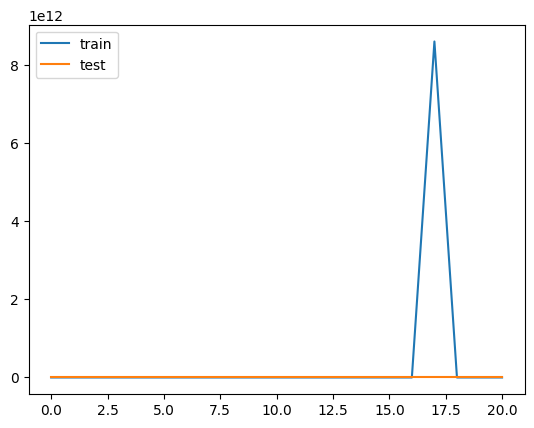

In [34]:
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
rms_LSTM = sqrt(min(lstm_history.history['val_loss']))

print("Root mean squared error on valid:",rms_LSTM)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_LSTM]).reshape(1, -1)))

Root mean squared error on valid: 0.0840268582082686
Root mean squared error on valid inverse transformed from normalization: [[83.52269706]]


## Visualization
Plot the prediction on the training set.

In [36]:
y_test_rolled_inversed = normalizers["pm2.5"].inverse_transform(y_test_rolled.reshape(-1, 1))
y_test_rolled_inversed.shape

(4257, 1)

In [37]:
y_predict = model_lstm.predict(X_test_rolled)

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [38]:
y_predict_inversed = normalizers["pm2.5"].inverse_transform(y_predict.reshape(-1, 1))
y_predict_inversed.shape

(4257, 1)

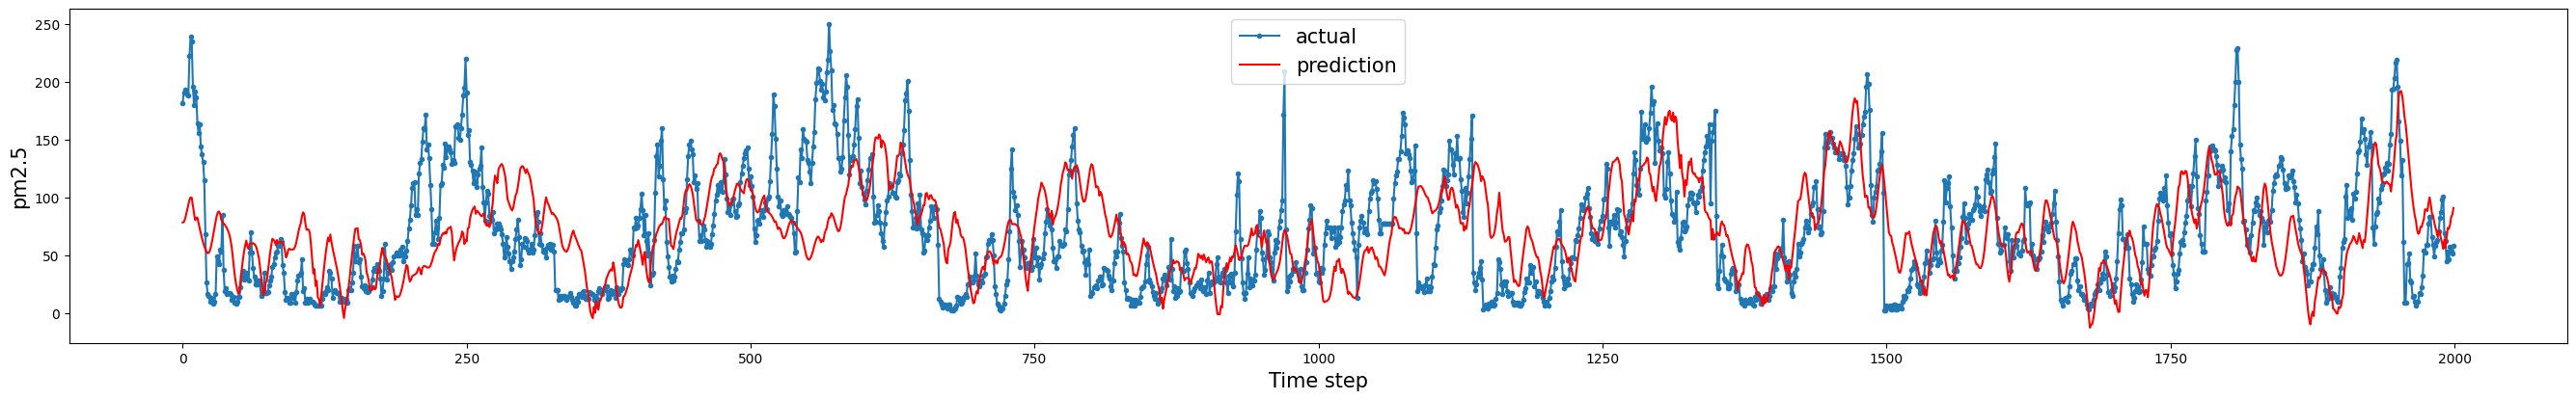

In [39]:
plt.figure(figsize=(28,4))
plt.plot(y_test_rolled_inversed[:2000], marker='.', label="actual")
plt.plot(y_predict_inversed[:2000], 'r', label="prediction")
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('pm2.5', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();